<a href="https://colab.research.google.com/github/MohammedYaseen97/END-3.0-Session-11-Assignment/blob/main/Session_11_Assignment_Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Tutorial- How To Build a Question Answering Bot

Article by Michel Kana: https://towardsdatascience.com/bert-nlp-how-to-build-a-question-answering-bot-98b1d1594d7b

Code credits to Michel Kana, and Prachur Bhargava, Lead Data Scientist @ Microsoft

In [1]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
# install huggingface libraries
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

In [5]:
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py'
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py'

!wget 'https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json'

--2022-01-29 16:27:53--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12493 (12K) [text/plain]
Saving to: ‘utils_squad_evaluate.py’

utils_squad_evaluat 100%[===================>]  12.20K  --.-KB/s    in 0s      

2022-01-29 16:27:53 (40.5 MB/s) - ‘utils_squad_evaluate.py’ saved [12493/12493]

--2022-01-29 16:27:54--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awai

In [6]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
input_file = 'train-v2.0.json'
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)

In [9]:
examples[:5]

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42,
 qas_id: 56be85543aeaaa14008c9065, question_text: What areas did Beyonce compete in when she was growing up?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈ

In [10]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
train_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


In [11]:
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
69346,5726bdcf708984140094cfef,What had Avicenna memorized by the age of 10?,"[According, to, his, autobiography,, Avicenna,...",Quran,9,9,False
69347,5726bdcf708984140094cff0,Who did Avicenna learn Indian arithmetic from?,"[According, to, his, autobiography,, Avicenna,...",ءMahmoud Massahi,22,23,False
69348,5726bdcf708984140094cff1,What did Avicenna learn from the Sunni scholar...,"[According, to, his, autobiography,, Avicenna,...",Fiqh (Islamic jurisprudence),49,51,False
69349,5726bdcf708984140094cff2,What was one philosophy book that Avicenna was...,"[According, to, his, autobiography,, Avicenna,...",Euclid's Elements,73,74,False
69350,5726bdcf708984140094cff3,What unpopular philosopher's text did Avicenna...,"[According, to, his, autobiography,, Avicenna,...",Abu Abdullah Nateli,81,83,False
69351,5ace3e6532bba1001ae4a01f,Who learned arithmatic by the age of 10?,"[According, to, his, autobiography,, Avicenna,...",,-1,-1,True
69352,5ace3e6532bba1001ae4a020,Who did AVicenna teach arithmatic to?,"[According, to, his, autobiography,, Avicenna,...",,-1,-1,True
69353,5ace3e6532bba1001ae4a021,When did Avicenna start studying the Quran?,"[According, to, his, autobiography,, Avicenna,...",,-1,-1,True
69354,5ace3e6532bba1001ae4a022,Who did Abu Abdullah Nateli teach Fiqh to.,"[According, to, his, autobiography,, Avicenna,...",,-1,-1,True
69355,5ace3e6532bba1001ae4a023,Who wrote Euclid's Elements?,"[According, to, his, autobiography,, Avicenna,...",,-1,-1,True


In [12]:
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))

In [13]:
print_squad_sample(train_data)

CONTEXT: 
The new interiors sought to recreate an authentically Roman and genuinely interior vocabulary. Techniques
employed in the style included flatter, lighter motifs, sculpted in low frieze-like relief or
painted in monotones en camaïeu ("like cameos"), isolated medallions or vases or busts or
bucrania or other motifs, suspended on swags of laurel or ribbon, with slender arabesques
against backgrounds, perhaps, of "Pompeiian red" or pale tints, or stone colours. The style
in France was initially a Parisian style, the Goût grec ("Greek style"), not a
court style; when Louis XVI acceded to the throne in 1774, Marie Antoinette, his
fashion-loving Queen, brought the "Louis XVI" style to court.
QUESTION:                                                                                            ANSWER:
What were interiors seeking to recreate?                                                             authentically Roman
What colors were utilized for interiors?                          

In [14]:

train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
116337,5a7e3cb870df9f001a875607,What do professional and amateur singers never...,"[Translations, of, sung, texts—whether, of, th...",,-1,-1,True,114,52
45128,570ff265b654c5140001f6dd,What is the only conviction that can lead to t...,"[In, 1976,, contemporaneously, with, Woodson, ...",first-degree murder,51,52,False,105,63
89829,57288c842ca10214002da465,Who proposed empirical falsification as the ce...,"[Popper, is, known, for, his, rejection, of, t...",Popper,0,0,False,112,87
107212,572f588204bcaa1900d76879,What were the Russians hoping to find in the p...,"[Four, years, into, the, 20th, century, saw, t...",warm water port,33,35,False,159,59
54432,572632a838643c19005ad2cf,"Due to discrimination, some Christians convert...","[The, Greek, Orthodox, Church, and, the, Ecume...",Islam,80,80,False,97,66


In [15]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 98.19289589392184%


In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 1908411.29B/s]


In [17]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 16

In [18]:
cached_features_file = 'cache_train'

In [19]:
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [20]:
offset = 5
features = features[::offset]

In [21]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [22]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [23]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [24]:
import glob
checkpoints = sorted(glob.glob('checkpoint*-[0-9]*'))

In [25]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [26]:
if len(checkpoints) > 0:
  global_step = checkpoints[-1].split('-')[-1]
  ckpt_name = 'checkpoint-{}'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

100%|██████████| 440473133/440473133 [00:12<00:00, 36607939.18B/s]


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [27]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[-0.0105, -0.0028, -0.0075,  ...,  0.0056,  0.0187, -0.0048],
        [-0.0040, -0.0352,  0.0193,  ..., -0.0038, -0.0129, -0.0292]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True))


In [28]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [29]:
num_train_epochs = 1

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    # count = 0
    for step, batch in enumerate(epoch_iterator):
      # print("Step : {}, GlobalStep : {}".format(step, global_step))
      if step < global_step + 1:
        continue
      # count += 1

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1

      # print("Global Step : ", global_step)
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = 'checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)

***** Running training *****
  Num examples = 28853
  Num Epochs = 1
  Batch size = 16
  Total optimization steps = 1803


Iteration:   0%|          | 0/1803 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)

Iteration:  55%|█████▌    | 1000/1803 [23:31<18:53,  1.41s/it]

Train loss: 1.7528305773735047



Iteration:  56%|█████▌    | 1001/1803 [23:34<26:08,  1.96s/it]

Saving model checkpoint to checkpoint-1000



Epoch: 100%|██████████| 1/1 [42:26<00:00, 2546.91s/it]


In [32]:
output_dir = 'checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
print("Saving model checkpoint to %s" % output_dir)

Saving model checkpoint to checkpoint-final


In [33]:
train_loss_set_ckpt = torch.load('checkpoint-final/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

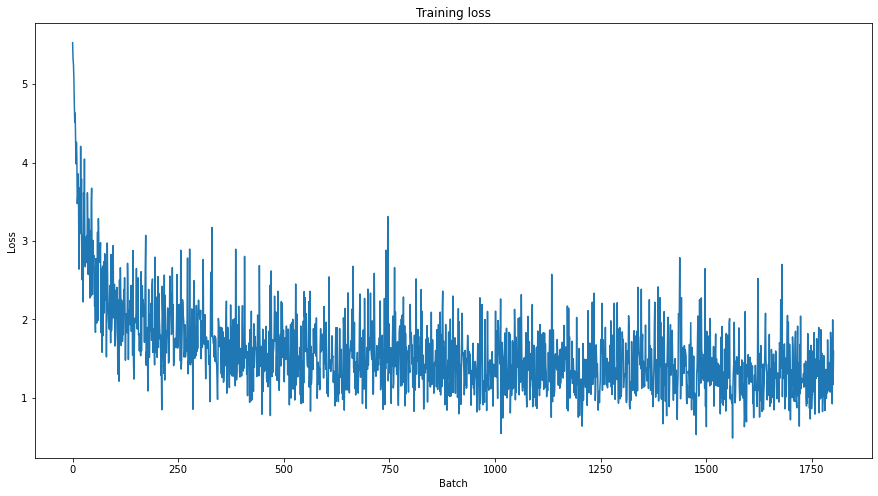

In [34]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

**Load test dataset**

In [38]:
!wget 'https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json'

--2022-01-29 17:30:23--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.111.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       100%[===================>]   4.17M  --.-KB/s    in 0.07s   

2022-01-29 17:30:23 (59.1 MB/s) - ‘dev-v2.0.json’ saved [4370528/4370528]



In [39]:
input_file = 'dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)
doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = 'cache_validation'

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [40]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [41]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

**Evaluate test dataset**

In [42]:

def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = 'dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "predictions.json"
  output_nbest_file = "nbest_predictions.json"
  output_null_log_odds_file = "null_odds.json"
  output_dir = "predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [43]:
results = evaluate(model, tokenizer)

***** Running evaluation *****
  Num examples = 13600
  Batch size = 16


Evaluating: 100%|██████████| 850/850 [06:54<00:00,  2.05it/s]


{
  "exact": 64.00235829192285,
  "f1": 66.59455781823293,
  "total": 11873,
  "HasAns_exact": 49.44331983805668,
  "HasAns_f1": 54.63515266124787,
  "HasAns_total": 5928,
  "NoAns_exact": 78.5197645079899,
  "NoAns_f1": 78.5197645079899,
  "NoAns_total": 5945,
  "best_exact": 64.08658300345321,
  "best_exact_thresh": -0.0842905044555664,
  "best_f1": 66.6370882591464,
  "best_f1_thresh": -0.0842905044555664
}


In [44]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('results.json', 'w') as f:
  json.dump(results_json, f)

[{'exact': 64.00235829192285}, {'f1': 66.59455781823293}, {'total': 11873}, {'HasAns_exact': 49.44331983805668}, {'HasAns_f1': 54.63515266124787}, {'HasAns_total': 5928}, {'NoAns_exact': 78.5197645079899}, {'NoAns_f1': 78.5197645079899}, {'NoAns_total': 5945}, {'best_exact': 64.08658300345321}, {'best_exact_thresh': -0.0842905044555664}, {'best_f1': 66.6370882591464}, {'best_f1_thresh': -0.0842905044555664}]


**Evaluate on any text**